In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly, sklearn_sm, Stepwise, sklearn_selected, sklearn_selection_path)
from functools import partial
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

c:\Users\admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import pygam as pg
from ISLP.transforms import BSpline, NaturalSpline
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam, anova as anova_gam)

In [3]:
wage = load_data('Wage')
y = wage['wage']
age = wage['age']

In [4]:
poly_age = MS([poly('age', degree=4)]).fit(wage)
M = sm.OLS(y, poly_age.transform(wage)).fit()
summarize(M)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [5]:
M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           2.77e-57
Time:                        11:37:21   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                111.7036      0.729    153.283      0.000     110.275     113.132
poly(age, degree=4)[0]   447.0679     39.915     11.201      0.000     368.805     525.331
poly(age, degree=4)[1]  -478.3158     39.915    -11.983      0.000    -556.579    -400.053
poly(age, degree=4)[2]   125.5217     39.915      3.145      0.002      47.259     203.785
poly(age, degree=4)[3]   -77.9112     39.915     -1.952      0.051    -156.174       0.352
==============================================================================
Omnibus:                     1097.594   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4965.521
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                         54.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age':age_grid})
age_df

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051
...,...
95,77.494949
96,78.121212
97,78.747475
98,79.373737


In [7]:
def plot_wage_fit(data, y, pred_data, basis, title):
    X = basis.transform(data)
    X_new = basis.transform(pred_data)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(X_new)
    bands = preds.conf_int(alpha=0.05)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.scatter(data['age'], y, facecolor='gray', alpha=0.5)
    for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]], ['b', 'r--', 'r--']):
        ax.plot(pred_data.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Age')
    ax.set_ylabel('Wage')
    return ax

<AxesSubplot:title={'center':'Degree-4 Polynomial'}, xlabel='Age', ylabel='Wage'>

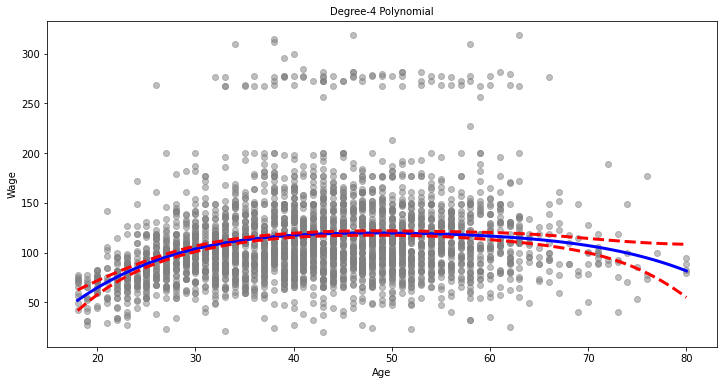

In [8]:
plot_wage_fit(wage, y, age_df, poly_age, 'Degree-4 Polynomial')

In [9]:
models = [MS([poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [10]:
models = [MS(['education', poly('age', degree=d)]) for d in range(1, 4)]
XEs = [model.fit_transform(wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [11]:
X = poly_age.transform(wage)
high_earn = wage['high_earn'] = y > 250
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Sat, 22 Feb 2025   Deviance:                       701.22
Time:                        11:37:21   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -4.3012      0.345    -12.457      0.000      -4.978      -3.624
poly(age, degree=4)[0]    71.9642     26.133      2.754      0.006      20.745     123.183
poly(age, degree=4)[1]   -85.7729     35.929     -2.387      0.017    -156.193     -15.353
poly(age, degree=4)[2]    34.1626     19.697      1.734      0.083      -4.442      72.767
poly(age, degree=4)[3]   -47.4008     24.105     -1.966      0.049     -94.646      -0.156
==========================================================================================
"""

In [12]:
X_new = poly_age.transform(age_df)
preds = B.get_prediction(X_new)
bands = preds.conf_int(alpha=0.05)
preds, bands

(<statsmodels.genmod._prediction.PredictionResults at 0x29f3afdbf70>,
 array([[5.78950866e-14, 1.66501818e-03],
        [6.47773454e-13, 2.02052150e-03],
        [6.17942160e-12, 2.43268648e-03],
        [5.06027729e-11, 2.90652765e-03],
        [3.58093552e-10, 3.44681663e-03],
        [2.20415980e-09, 4.05797983e-03],
        [1.18761836e-08, 4.74401075e-03],
        [5.63630090e-08, 5.50840627e-03],
        [2.37040935e-07, 6.35413786e-03],
        [8.88635779e-07, 7.28366973e-03],
        [2.98664679e-06, 8.29903800e-03],
        [9.04937098e-06, 9.40200705e-03],
        [2.48522219e-05, 1.05943223e-02],
        [6.21842888e-05, 1.18780814e-02],
        [1.42473459e-04, 1.32562486e-02],
        [3.00331810e-04, 1.47333330e-02],
        [5.85141969e-04, 1.63162329e-02],
        [1.05826357e-03, 1.80151925e-02],
        [1.78397657e-03, 1.98446737e-02],
        [2.81430650e-03, 2.18236488e-02],
        [4.17108698e-03, 2.39743001e-02],
        [5.83177501e-03, 2.63174781e-02],
      

In [13]:
preds.predicted_mean

array([9.82634924e-09, 3.62144997e-08, 1.22756875e-07, 3.84066373e-07,
       1.11290122e-06, 2.99680270e-06, 7.52385849e-06, 1.76685882e-05,
       3.89320544e-05, 8.07401522e-05, 1.58069266e-04, 2.92985053e-04,
       5.15600605e-04, 8.63866011e-04, 1.38167400e-03, 2.11504676e-03,
       3.10662355e-03, 4.38918130e-03, 5.97932625e-03, 7.87263665e-03,
       1.00413397e-02, 1.24351072e-02, 1.49849011e-02, 1.76091864e-02,
       2.02214219e-02, 2.27376206e-02, 2.50829298e-02, 2.71965121e-02,
       2.90344109e-02, 3.05704401e-02, 3.17954019e-02, 3.27150742e-02,
       3.33474475e-02, 3.37196467e-02, 3.38648912e-02, 3.38197418e-02,
       3.36217827e-02, 3.33078060e-02, 3.29124978e-02, 3.24675830e-02,
       3.20013618e-02, 3.15385555e-02, 3.11003855e-02, 3.07048091e-02,
       3.03668526e-02, 3.00989886e-02, 2.99115194e-02, 2.98129370e-02,
       2.98102378e-02, 2.99091776e-02, 3.01144562e-02, 3.04298234e-02,
       3.08580987e-02, 3.14011005e-02, 3.20594785e-02, 3.28324426e-02,
      

In [14]:
cut_age = pd.qcut(age, 4)
model = sm.OLS(y, pd.get_dummies(cut_age)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     63.30
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           1.12e-39
Time:                        11:37:22   Log-Likelihood:                -15358.
No. Observations:                3000   AIC:                         3.072e+04
Df Residuals:                    2996   BIC:                         3.075e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
(17.999, 33.75]    94.1584      1.478     63.692      0.000      91.260      97.057
(33.75, 42.0]     116.6608      1.470     79.385      0.000     113.779     119.542
(42.0, 51.0]      119.1887      1.416     84.147      0.000     116.411     121.966
(51.0, 80.0]      116.5717      1.559     74.751      0.000     113.514     119.629
==============================================================================
Omnibus:                     1062.319   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4546.061
Skew:                           1.681   Prob(JB):                         0.00
Kurtosis:                       8.006   Cond. No.                         1.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
pd.get_dummies(cut_age)

,"(17.999, 33.75]","(33.75, 42.0]","(42.0, 51.0]","(51.0, 80.0]"
0,True,False,False,False
1,True,False,False,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False
...,...,...,...,...
2995,False,False,True,False
2996,True,False,False,False
2997,True,False,False,False
2998,True,False,False,False


In [16]:
bs_ = BSpline(internal_knots=[25, 40, 60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [18]:
bs_age = MS([bs('age', internal_knots=[25, 40, 60], name='bs(age)')])
X_bs = bs_age.fit_transform(wage)
model = sm.OLS(y, X_bs).fit()
model.summary()

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     47.19
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           1.53e-55
Time:                        11:42:20   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2993   BIC:                         3.068e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     60.4937      9.460      6.394      0.000      41.944      79.043
bs(age)[0]     3.9805     12.538      0.317      0.751     -20.603      28.564
bs(age)[1]    44.6310      9.626      4.636      0.000      25.756      63.506
bs(age)[2]    62.8388     10.755      5.843      0.000      41.750      83.927
bs(age)[3]    55.9908     10.706      5.230      0.000      34.998      76.983
bs(age)[4]    50.6881     14.402      3.520      0.000      22.450      78.927
bs(age)[5]    16.6061     19.126      0.868      0.385     -20.896      54.108
==============================================================================
Omnibus:                     1096.233   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4953.521
Skew:                           1.720   Prob(JB):                         0.00
Kurtosis:                       8.273   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

In [20]:
ns_age = MS([ns('age', df=5)]).fit(wage)
model = sm.OLS(y, ns_age.transform(wage)).fit()
model.summary()

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     56.94
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           9.90e-57
Time:                        11:46:55   Log-Likelihood:                -15314.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2994   BIC:                         3.068e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           60.4752      4.708     12.844      0.000      51.243      69.707
ns(age, df=5)[0]    61.5267      4.709     13.065      0.000      52.293      70.761
ns(age, df=5)[1]    55.6912      5.717      9.741      0.000      44.481      66.901
ns(age, df=5)[2]    46.8184      4.948      9.463      0.000      37.117      56.519
ns(age, df=5)[3]    83.2036     11.918      6.982      0.000      59.836     106.571
ns(age, df=5)[4]     6.8770      9.484      0.725      0.468     -11.719      25.473
==============================================================================
Omnibus:                     1090.232   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4894.901
Skew:                           1.711   Prob(JB):                         0.00
Kurtosis:                       8.239   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
X_age = np.asarray(age).reshape((-1, 1))
gam = pg.LinearGAM(pg.s(0, lam=0.6))
gam.fit(X_age, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

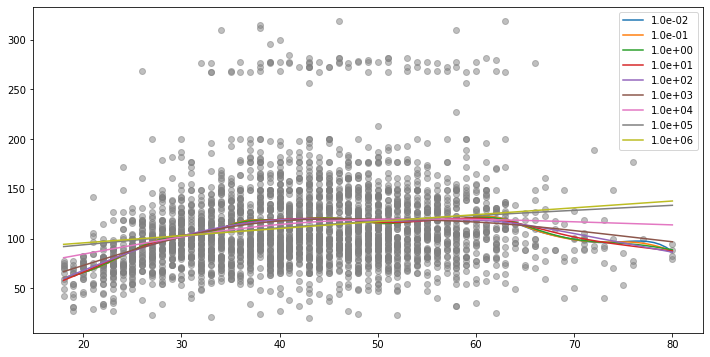

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.scatter(age, y, facecolor='gray', alpha=.5)
for lam in np.logspace(-2, 6, 9):
    gam = pg.LinearGAM(pg.s(0, lam=lam)).fit(X_age, y)
    ax.plot(age_grid, gam.predict(age_grid), label='{:.1e}'.format(lam))
ax.legend()

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


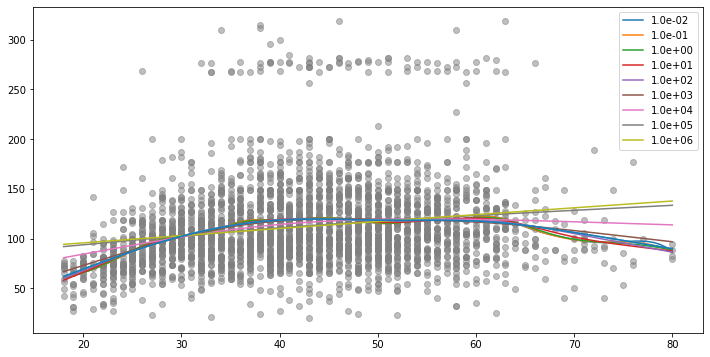

In [29]:
gam_opt = gam.gridsearch(X_age, y)
ax.plot(age_grid, gam_opt.predict(age_grid))
ax.legend()
fig

In [30]:
age_term = gam.terms[0]
lam_4 = approx_lam(X_age, age_term, 4)
age_term.lam = lam_4
degrees_of_freedom(X_age, age_term)

4.000000100000289

In [31]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(wage['year'])
Xs = [ns_age.transform(age), ns_year.transform(wage['year']), pd.get_dummies(wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()
gam_bh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     94.86
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          8.30e-213
Time:                        15:46:43   Log-Likelihood:                -14931.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2986   BIC:                         2.997e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            46.4460      3.732     12.446      0.000      39.129      53.763
x2            28.9349      3.884      7.449      0.000      21.319      36.551
x3            63.6722      9.231      6.898      0.000      45.572      81.772
x4            10.9669      7.650      1.434      0.152      -4.034      25.967
x5             1.8374      3.177      0.578      0.563      -4.392       8.067
x6            10.4409      3.790      2.755      0.006       3.010      17.872
x7             2.0020      3.399      0.589      0.556      -4.663       8.667
x8             9.6055      4.053      2.370      0.018       1.659      17.552
x9             5.8989      2.419      2.438      0.015       1.155      10.642
x10           43.8013      4.383      9.993      0.000      35.207      52.396
x11           54.7329      4.037     13.558      0.000      46.817      62.649
x12           67.1982      4.159     16.156      0.000      59.043      75.354
x13           81.9664      4.231     19.371      0.000      73.670      90.263
x14          106.3711      4.456     23.872      0.000      97.634     115.108
==============================================================================
Omnibus:                     1040.093   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5576.947
Skew:                           1.556   Prob(JB):                         0.00
Kurtosis:                       8.910   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
pd.DataFrame(X_bh)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,0.000000,0.000000,0.000000,0.333333,0.583333,0.080128,0.012821,-0.009615,1.0,0.0,0.0,0.0,0.0
1,0.017316,-0.137954,0.318722,-0.180767,0.166667,0.000000,-0.124035,0.496139,-0.372104,0.0,0.0,0.0,1.0,0.0
2,0.751086,0.166050,0.091316,-0.050613,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0
3,0.780172,0.072225,0.110026,-0.062359,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
4,0.529332,0.388794,0.137083,-0.055404,0.708333,0.125000,-0.031009,0.124035,-0.093026,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.772273,0.118523,0.096815,-0.054561,0.000000,0.083333,0.522436,0.243590,0.150641,0.0,0.0,1.0,0.0,0.0
2996,0.138528,-0.213620,0.493536,-0.279916,0.041667,0.458333,0.435897,0.089744,-0.025641,0.0,1.0,0.0,0.0,0.0
2997,0.058442,-0.187466,0.433111,-0.245645,0.708333,0.125000,-0.031009,0.124035,-0.093026,1.0,0.0,0.0,0.0,0.0
2998,0.058442,-0.187466,0.433111,-0.245645,0.708333,0.125000,-0.031009,0.124035,-0.093026,0.0,0.0,1.0,0.0,0.0


In [37]:
gam_full = pg.LinearGAM(pg.s(0) + pg.s(1, n_splines=7) + pg.f(2, lam=0))
X_gam = np.column_stack([age, wage['year'], wage['education'].cat.codes])
gam_full = gam_full.fit(X_gam, y)

<AxesSubplot:>

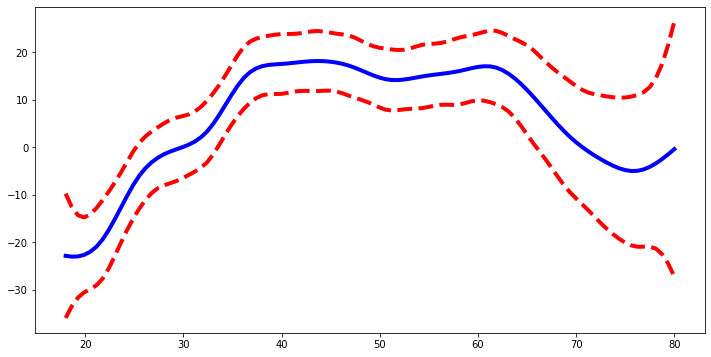

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_gam(gam_full, 0, ax=ax)

In [45]:
age_term = gam_full.terms[0]
age_term.lam = approx_lam(X_gam, age_term, df=4+1)
year_term = gam_full.terms[1]
year_term.lam = approx_lam(X_gam, year_term, df=4+1)
gam_full = gam_full.fit(X_gam, y)

<AxesSubplot:>

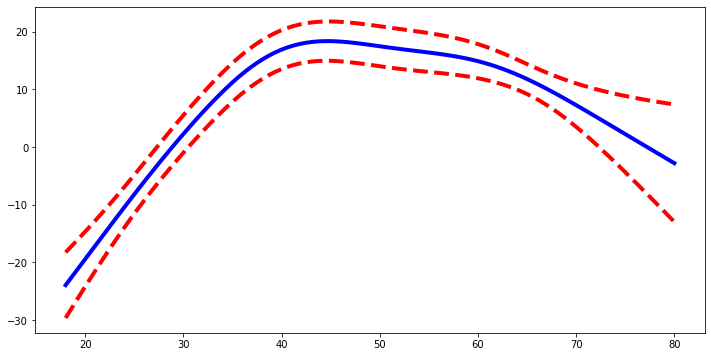

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_gam(gam_full, 0, ax=ax)

In [47]:
gam_0 = pg.LinearGAM(age_term + pg.f(2, lam=0))
gam_0.fit(X_gam, y)
gam_li = pg.LinearGAM(age_term + pg.l(1, lam=0) + pg.f(2, lam=0))
gam_li.fit(X_gam, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + l(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [48]:
anova_gam(gam_0, gam_li, gam_full)

,deviance,df,deviance_diff,df_diff,F,pvalue
0,3.714362e+06,2991.004005,NaN,NaN,NaN,NaN
1,3.696746e+06,2990.005190,17616.542840,0.998815,14.265131,0.002314
2,3.693143e+06,2987.007254,3602.893655,2.997936,0.972007,0.435579


In [49]:
gam_full.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.9927
Link Function:                     IdentityLink Log Likelihood:                                 -24117.907
Number of Samples:                         3000 AIC:                                            48263.7995
                                                AICc:                                             48263.94
                                                GCV:                                             1246.1129
                                                Scale:                                           1236.4024
                                                Pseudo R-Squared:                                   0.2928
Feature Function                  Lam

C:\Users\admin\AppData\Local\Temp\ipykernel_25576\3870570873.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_full.summary()


In [50]:
y_hat = gam_full.predict(X_gam)
y_hat

array([ 52.3662492 ,  99.63834745, 111.7723448 , ...,  70.20962308,
        93.60649596, 104.91135937])

In [51]:
gam_logit = pg.LogisticGAM(age_term + pg.s(1, lam=0.6) + pg.f(2, lam=0))
gam_logit.fit(X_gam, high_earn)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

<AxesSubplot:>

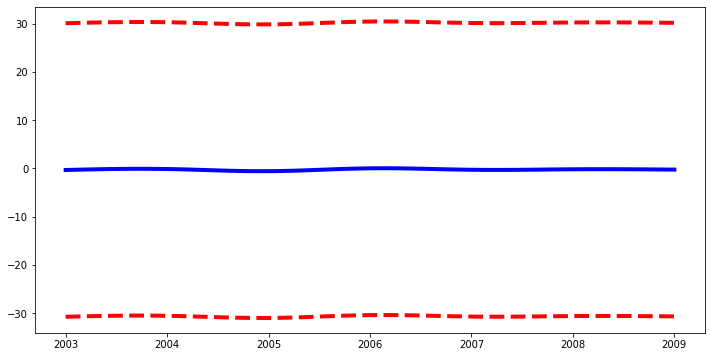

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_gam(gam_logit, 1, ax=ax)

In [55]:
only_hs = wage['education'] == '1. < HS Grad'
wage_ = wage.loc[~only_hs]
X_gam_ = np.column_stack([wage_['age'], wage_['year'], wage_['education'].cat.codes-1])
high_earn_ = wage_['high_earn']

In [56]:
gam_logit_ = pg.LogisticGAM(age_term + year_term + pg.f(2, lam=0))
gam_logit_.fit(X_gam_, high_earn_)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + f(2) + intercept, tol=0.0001, verbose=False)

<AxesSubplot:>

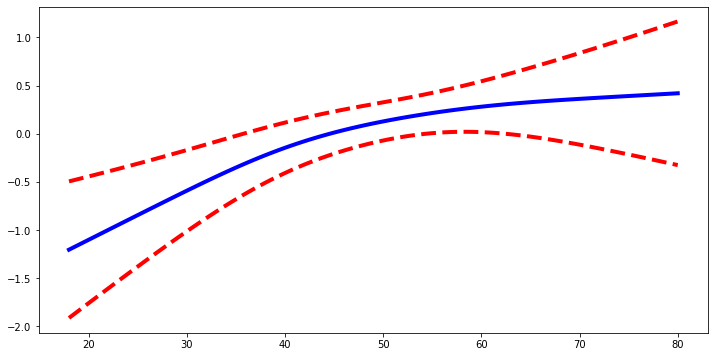

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_gam(gam_logit_, 0, ax=ax)

<AxesSubplot:>

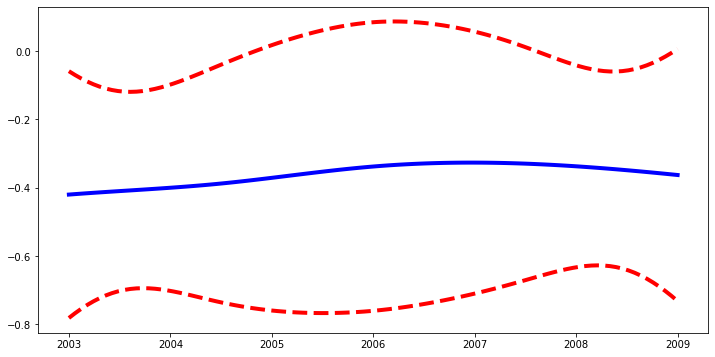

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_gam(gam_logit_, 1, ax=ax)

<AxesSubplot:>

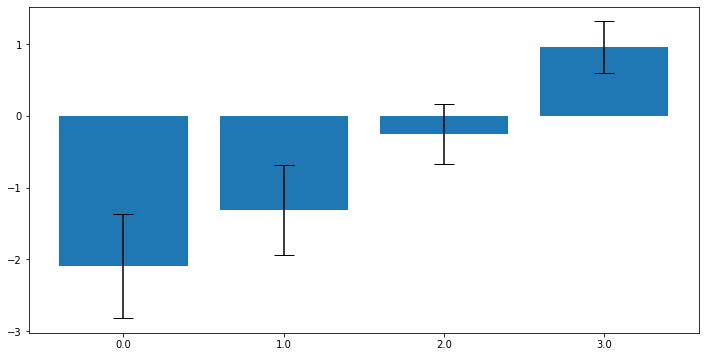

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_gam(gam_logit_, 2, ax=ax)

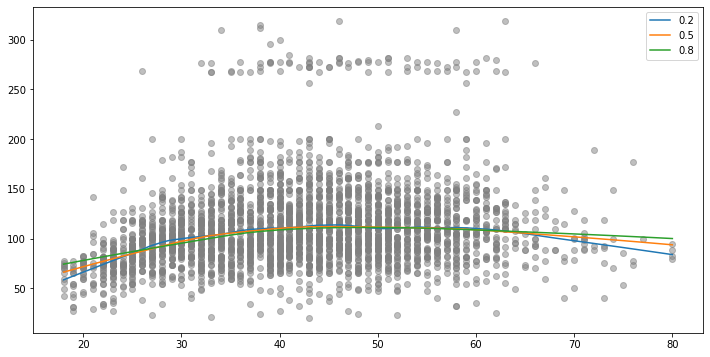

In [61]:
lowess = sm.nonparametric.lowess
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(age, y, facecolor='gray', alpha=.5)
for span in [0.2, 0.5, 0.8]:
    fitted = lowess(y, age, frac=span, xvals=age_grid)
    ax.plot(age_grid, fitted, label=f'{span:.1f}')
ax.legend()